In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from isochrones import get_ichrone
from astropy.table import Table
import numpy as np
import math as m
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import interpolate

print('Modules imported')

Modules imported


In [81]:
M52_data_path = 'Data/final_catalogue_M52_2sigma.fits'
cluster_data = Table.read(M52_data_path, format='fits')

# filter and extract data from .fits file
snr_threshold = 3
ok = ((cluster_data['flux_v']/cluster_data['fluxerr_v'] > snr_threshold) &
      (cluster_data['flux_b']/cluster_data['fluxerr_b'] > snr_threshold))
cluster_data = cluster_data[ok]

cluster_mag_v = np.array(cluster_data['mag_v'].tolist())
cluster_mag_b = np.array(cluster_data['mag_b'].tolist())
cluster_magerr_v = np.array(cluster_data['magerr_v'].tolist())
cluster_magerr_b = np.array(cluster_data['magerr_b'].tolist())
cluster_mag_v = cluster_mag_v.astype(float)
cluster_mag_b = cluster_mag_b.astype(float)
cluster_magerr_v = cluster_magerr_v.astype(float)
cluster_magerr_b = cluster_magerr_b.astype(float)
cluster_bv = cluster_mag_b - cluster_mag_v
cluster_err_bv = np.sqrt(cluster_magerr_v**2 + cluster_magerr_b**2)
cluster_mag_v = np.array(cluster_mag_v)
cluster_bv = np.array(cluster_bv)

# Intersteller Dust Extinction Coefficient
AV = 3.1443
AV_err = 0.6248
RV = 3.1
ExtBV = RV/AV

# Distance
dis = 1315.0513 # pc
dis_err = 195 # pc

cluster_mag_v_true = cluster_mag_v - AV
cluster_bv_true = cluster_bv - ExtBV

delete_index = []
for i in range(len(cluster_bv_true)):
    if cluster_bv_true[i] < -0.32: # remove data point causing error
        delete_index.append(i)

cluster_mag_v_true = np.delete(cluster_mag_v_true, delete_index)
cluster_mag_v = np.delete(cluster_mag_v, delete_index)
cluster_bv = np.delete(cluster_bv, delete_index)
cluster_magerr_v = np.delete(cluster_magerr_v, delete_index)
cluster_bv_true = np.delete(cluster_bv_true, delete_index)
cluster_err_bv = np.delete(cluster_err_bv, delete_index)

cluster_Mag_v = cluster_mag_v_true - 5*m.log10(dis/10)
cluster_Magerr_v = np.sqrt(cluster_magerr_v**2+AV_err**2+(250/dis**2)*dis_err**2/(np.log(10)**2))

In [8]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'sans-serif'

iso = get_ichrone('mist', bands=['B', 'V'])

age=8.5
feh=0.0

model_df = iso.isochrone(age=age, feh=feh)

In [4]:
mist = get_ichrone('mist')

print("Available bands in MIST:")
print(mist.bands)

print("All columns in the DataFrame:")
print(model_df.columns.tolist())

Available bands in MIST:
['J', 'H', 'K', 'G', 'BP', 'RP', 'W1', 'W2', 'W3', 'TESS', 'Kepler']
All columns in the DataFrame:
['eep', 'age', 'feh', 'mass', 'initial_mass', 'radius', 'density', 'logTeff', 'Teff', 'logg', 'logL', 'Mbol', 'delta_nu', 'nu_max', 'phase', 'dm_deep', 'B_mag', 'V_mag']


In [21]:
eep_bins = [0, 200, 450, 650, 1000, 1300, 1700, 2000]
eep_labels = ['Pre-MS', 'Main Seq', 'Subgiant', 'RGB', 
              'He-burning', 'AGB', 'Post-AGB']
eep_colours = ['blue', 'purple', 'red', 'orange', 
              'yellow', 'green', 'pink']

# select just one phase
Phase_mask = (model_df['eep'] > 200) & (model_df['eep'] < 450)
model_df = model_df[Phase_mask]

cmap = ListedColormap(eep_colours) # create colour chart for phases
norm = BoundaryNorm(eep_bins, len(eep_colours))

model_colour = model_df['B_mag'] - model_df['V_mag'] # colour
model_mag = model_df['V_mag'] # V Magnitude

In [31]:
MCMM = list(set(zip(model_colour, model_mag))) # sort the data for function fitting
MCMM.sort(key=lambda x: x[1])
BV_sorted = [item[0] for item in MCMM]
V_sorted = [item[1] for item in MCMM]

f1 = interpolate.interp1d(BV_sorted, V_sorted, kind='linear', bounds_error=False, fill_value='extrapolate') # function
xmin, xmax = np.min(BV_sorted), np.max(BV_sorted)
x = np.arange(xmin, xmax, 0.001)
y = f1(x)

-0.0765212660700455
-0.0765212660700455


In [89]:
age_values = np.arange(7.5, 9, 0.01)
feh_values = np.arange(-1, 0.5, 0.01)
iso = get_ichrone('mist', bands=['B', 'V'])

chi2_grid = np.zeros((len(age_values), len(feh_values)))


for i in range(0, len(age_values)):
    for j in range(0, len(feh_values)):

        print(f'{i+1}/{len(age_values)}, {j+1}/{len(feh_values)}', end='\r')
        model_df = iso.isochrone(age=age_values[i], feh=feh_values[j])
        
        # Sort evolutionary phases
        eep_bins = [0, 200, 450, 650, 1000, 1300, 1700, 2000]
        eep_labels = ['Pre-MS', 'Main Seq', 'Subgiant', 'RGB', 'He-burning', 'AGB', 'Post-AGB']
        eep_colours = ['blue', 'purple', 'red', 'orange', 'yellow', 'green', 'pink']

        # select just one phase
        Phase_mask = (model_df['eep'] > 200) & (model_df['eep'] < 450)
        model_df = model_df[Phase_mask]

        # create colour chart for phases
        cmap = ListedColormap(eep_colours)
        norm = BoundaryNorm(eep_bins, len(eep_colours))

        model_colour = model_df['B_mag'] - model_df['V_mag'] # Colour
        model_mag = model_df['V_mag'] # V Magnitude

        # Sort the data for function fitting
        MCMM = list(set(zip(model_colour, model_mag)))
        MCMM.sort(key=lambda x: x[1])
        BV_sorted = [item[0] for item in MCMM]
        V_sorted = [item[1] for item in MCMM]

        # Function to fit isochrone to
        f = interpolate.interp1d(BV_sorted, V_sorted, kind='linear', bounds_error=False, fill_value='extrapolate')
        xmin, xmax = np.min(BV_sorted), np.max(BV_sorted)
        x = np.arange(xmin, xmax, 0.001)
        y = f(x)

        # Chi2 Calculations
        expected_V = f(cluster_bv_true)

        residuals = cluster_Mag_v - expected_V
        chi2 = np.sum((residuals**2)/np.abs(cluster_Magerr_v+1e-20)**2)/(len(cluster_Mag_v)-2)
        chi2_grid[i, j] = chi2

print()

min_value = np.min(chi2_grid)
print(f"Global minimum: {min_value}")

min_value = np.min(chi2_grid)
min_index = np.argmin(chi2_grid)
print(f"Min value: {min_value}, Flattened index: {min_index}")

min_coords = np.unravel_index(min_index, chi2_grid.shape)
print(f"Min value: {min_value} at coordinates: {min_coords}")

age_index, feh_index = min_coords
best_age = age_values[age_index]
best_feh = feh_values[feh_index]
best_model = iso.isochrone(age=best_age, feh=best_feh)

best_model_colour = best_model['B_mag'] - best_model['V_mag'] # Colour
best_model_mag = best_model['V_mag'] # V Magnitude

150/150, 150/150
Global minimum: 1.6680876862201186
Min value: 1.6680876862201186, Flattened index: 4497
Min value: 1.6680876862201186 at coordinates: (29, 147)


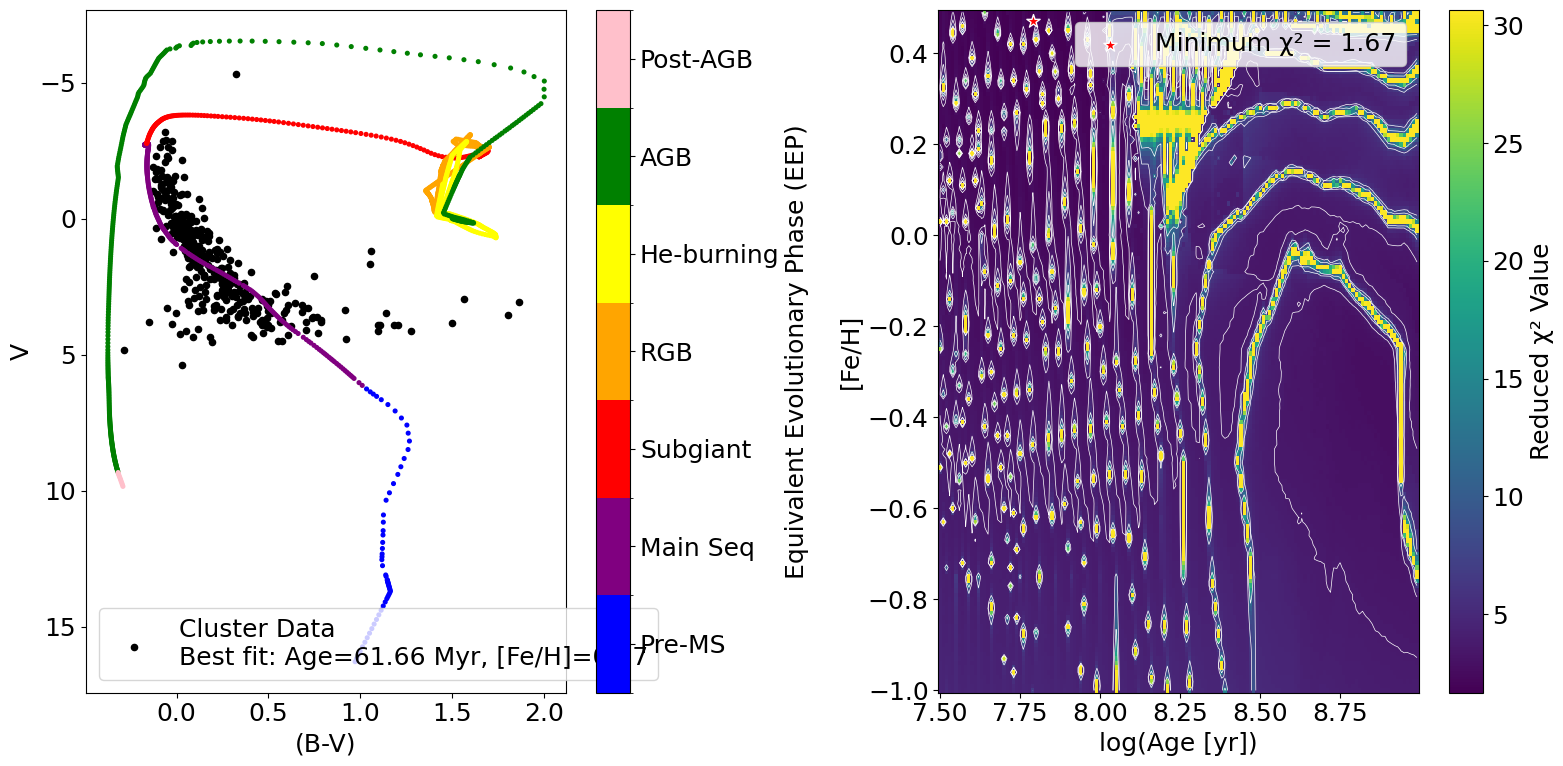

Best-fit parameters:
  Age: 7.79 (log years) = 61.66 Myr
  [Fe/H]: 0.47
  Minimum Reduced χ²: 1.67


In [90]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Isochrone fit
ax1 = axes[0]
sc = ax1.scatter(best_model_colour, best_model_mag, 
                 c=best_model['eep'], 
                 cmap=cmap, norm=norm, s=7, zorder=5)
ax1.scatter(cluster_bv_true, cluster_Mag_v, c='black', s=20,
            label=f'Cluster Data\nBest fit: Age={((10**best_age)/10**6):.2f} Myr, [Fe/H]={best_feh:.2f}')
ax1.set_xlabel('(B-V)')
ax1.set_ylabel('V')
ax1.invert_yaxis()
ax1.legend()

# Add colorbar with eep labels
cbar1 = plt.colorbar(sc, ax=ax1, ticks=(np.array(eep_bins[:-1]) + np.array(eep_bins[1:]))/2)
cbar1.ax.set_yticklabels(eep_labels)
cbar1.set_label('Equivalent Evolutionary Phase (EEP)')

# Plot 2: Chi-squared grid
ax2 = axes[1]

# Create meshgrid
age_mesh, feh_mesh = np.meshgrid(age_values, feh_values, indexing='ij')

# Plot chi-squared values as a colormap
im = ax2.pcolormesh(age_mesh, feh_mesh, chi2_grid, 
                     cmap='viridis', shading='auto', 
                     vmin=np.min(chi2_grid), vmax=np.percentile(chi2_grid, 95))

# Mark the minima point
ax2.scatter(best_age, best_feh, color='red', s=100, marker='*', 
            edgecolor='white', linewidth=1, zorder=5, 
            label=f'Minimum χ² = {np.min(chi2_grid):.2f}')

# Add colorbar for chi-squared plot
cbar2 = plt.colorbar(im, ax=ax2)
cbar2.set_label('Reduced χ² Value')
ax2.set_xlabel('log(Age [yr])')
ax2.set_ylabel('[Fe/H]')

# contour lines at certain chi-squared levels
levels = [np.min(chi2_grid), np.min(chi2_grid)+1, np.min(chi2_grid)+2, np.min(chi2_grid)+5, np.min(chi2_grid)+10]
ax2.contour(age_mesh, feh_mesh, chi2_grid, levels=levels, colors='white', alpha=1, linewidths=0.5)

ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#Print the best-fit parameters
print(f"Best-fit parameters:")
print(f"  Age: {best_age:.2f} (log years) = {(10**best_age)/10**6:.2f} Myr")
print(f"  [Fe/H]: {best_feh:.2f}")
print(f"  Minimum Reduced χ²: {np.min(chi2_grid):.2f}")